In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


In [2]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.losses import MeanAbsolutePercentageError

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [4]:
DIR_DATA  = '../input/diploma/'

In [21]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

# Вспомогательные функции расчета метрик.

In [6]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [8]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

# Общие сведения, задачи, примерный план работы.

In [9]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Задачи на текущем этапе

1. С точки зрения здравого смысле должна быть корреляция между улицей и городом. Возможны проблемы с сочетанием популярности улицы - непопулярности города и наоборот. Что с этим делать пока непонятно.

2. Признак школы объединяет три фрагмента информации: рейтинг школы, удаленность от школы, название школы. С точки зрения здравого смысла, рейтинг и удаленность должны заметно влиять на цену. Проблема с признаком: неряшливая запись, практически невозможно выделить какой-то формат. Пока работаю над ним.

3.  mls_id и MLSID: похоже, одно и то же. Посмотреть распределение значений mls_id, скорее всего, можно будет просто выкинуть. MLSID, наверное, тоже.  # удалено. Скорее всего, на цену не влияет.

4. Признак факты содержит дополнительную информацию. В признаке хорошо выделяется структура: список словарей. Написана функция, выделяющая собственно этот список, в которой проявляется ошибка. Работаю над исправлением.


# Текущая модель

Из предварительной выборки удалены признаки:

private pool

улица

mls_id и MLSID

общий признак школы

общий признак факты

    
# Дальнейшие задачи

1. Обработка признаков школы и факты, добавление новых столбцов в датасет, добавление в модель.

2. Эксперименты с моделями.

3. Провести более точное удаление выбросов целевой переменной, посмотреть результаты.

Удалено, потому что громоздко.

# Анализ целевой переменной.

In [10]:
data_d.head(10)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,NaN,NaN,PAPH847006,"$209,000"
6,Active,NaN,Florida,552 Casanova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",34759,NaN,FL,One,NaN,NaN,S5026943,"181,500"
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,"68,000"
8,Active,NaN,Single Family Home,11182 Owl Ave,2,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588,50401,3,IA,NaN,NaN,NaN,190988,"$244,900"
9,NaN,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",77080,3,TX,2.0,NaN,NaN,73968331,"$311,995"


# Вспомогательная функция извлечения числа из записи доллара.

In [11]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return np.NaN
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return float(dollar_res)


In [12]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [13]:
data_d['target'].isna().unique()

array([False,  True])

In [14]:
data_d['target'].value_counts()

225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
325000.0    1562
            ... 
236070.0       1
752911.0       1
73360.0        1
455740.0       1
171306.0       1
Name: target, Length: 34232, dtype: int64

In [15]:
data_d['target'].fillna(value = data_d.target.median(), inplace = True)

# Заполнить недостающие значения после оформления признака площадь.

In [16]:
data_d['target'].isna().unique()

array([False])

<AxesSubplot:xlabel='target', ylabel='Density'>

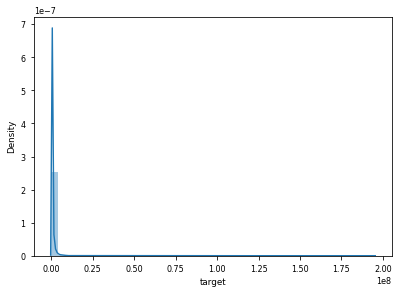

In [17]:
sns.distplot(data_d['target'])

Предварительное грубое удаление выбросов.

In [18]:
data_d.loc[data_d['target'].median()]

status                                                     Active
private pool                                                  NaN
propertyType                        Condo/Townhome/Row Home/Co-Op
street                              1080 Wisconsin Ave NW Apt 304
baths                                                         1.5
homeFacts       {'atAGlanceFacts': [{'factValue': '1981', 'fac...
fireplace                                                     NaN
city                                                   Washington
schools         [{'rating': ['8', '8', '8', '8', '9', '9', 'NR...
sqft                                                          946
zipcode                                                     20007
beds                                                            1
state                                                          DC
stories                                                        3+
mls-id                                                        NaN
PrivatePoo

In [19]:
data_d = data_d[(data_d['target'] < 550000)]

<AxesSubplot:xlabel='target', ylabel='Density'>

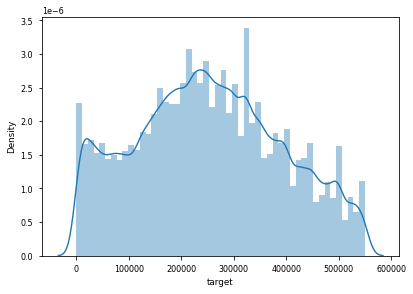

In [20]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f1a9ac46b90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f1a9ac783d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f1a9ac46bd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f1a9ac98410>}

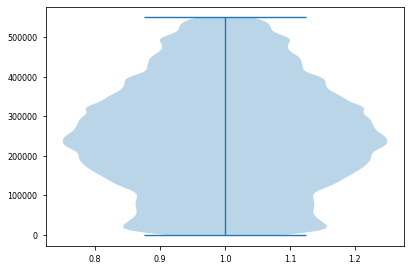

In [21]:
plt.violinplot(data_d['target'])

In [22]:
data_d['target'].isna().unique()

array([False])

In [23]:
data_d.loc[data_d['target']==0]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


In [24]:
data_d.loc[data_d['target'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                   1,947 sqft
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

In [25]:
#data_d.target = np.log(data_d.target[data_d.target > 0])

In [26]:
#data_d['target'].isna().unique()

# Площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, возвращает NaN.

In [27]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return np.NaN
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [28]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

In [29]:
data_d['sqft'].value_counts()

0.0        10652
1200.0      1232
1000.0       906
1100.0       798
1500.0       769
           ...  
8754.0         1
64.0           1
6223.0         1
46996.0        1
7644.0         1
Name: sqft, Length: 5854, dtype: int64

Вместо нулевых значений подставляю нан для упрощения последующей замены.

In [30]:
data_d.sqft = data_d.sqft.apply(lambda x: np.NaN if x==0.0 else x)

In [31]:
data_d['sqft'].value_counts()

1200.0     1232
1000.0      906
1100.0      798
1500.0      769
1400.0      749
           ... 
8754.0        1
64.0          1
6223.0        1
46996.0       1
7644.0        1
Name: sqft, Length: 5853, dtype: int64

In [32]:
data_d['sqft'].unique()

array([2.90000000e+03, 1.94700000e+03,            nan, ...,
       7.20000000e+01, 4.56602479e+08, 7.64400000e+03])

In [33]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276948 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        246827 non-null  object 
 1   private pool  2742 non-null    object 
 2   propertyType  253129 non-null  object 
 3   street        276947 non-null  object 
 4   baths         194069 non-null  object 
 5   homeFacts     276948 non-null  object 
 6   fireplace     67586 non-null   object 
 7   city          276928 non-null  object 
 8   schools       276948 non-null  object 
 9   sqft          235646 non-null  float64
 10  zipcode       276948 non-null  object 
 11  beds          207050 non-null  object 
 12  state         276948 non-null  object 
 13  stories       169302 non-null  object 
 14  mls-id        19149 non-null   object 
 15  PrivatePool   22749 non-null   object 
 16  MlsId         224599 non-null  object 
 17  target        276948 non-null  float64
dtypes: f

# Заполнить пропуски по комнатам

In [34]:
data_d.loc[data_d['sqft'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                       1947.0
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

# Спальни - приведение к численному виду.

In [35]:
data_d['beds'].value_counts()

3 Beds        42890
4 Beds        24758
3             24356
2 Beds        20440
4             12920
              ...  
40 acres          1
6.53 acres        1
9,291 sqft        1
6,115 sqft        1
8,479 sqft        1
Name: beds, Length: 959, dtype: int64

In [36]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor')[0])

In [37]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
364340,A Active,NaN,Land,4500 Harris Hill Rd,NaN,"{'atAGlanceFacts': [{'factValue': '1922', 'fac...",NaN,Falconer,"[{'rating': ['5', '5', 'NR', 'NR', 'NR'], 'dat...",1596.0,14733,# Bedrooms 1st Floor,NY,NaN,NaN,NaN,R1171774,79000.0


Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [38]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [39]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [40]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor'))
data_d.beds = data_d.beds.apply(lambda x: 1 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('sqft')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('acres')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('# Bedrooms 1st Floor')>-1) else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

1                                                                         157719
3 Beds                                                                     42890
4 Beds                                                                     24758
2 Beds                                                                     20440
3 bd                                                                       11138
4 bd                                                                        6106
5 Beds                                                                      4814
2 bd                                                                        4650
5 bd                                                                        1317
6 Beds                                                                      1142
1 bd                                                                         982
6 bd                                                                         266
7 Beds                      

In [41]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


Вспомогательная функция для выбора числового значения признака спальни.

In [42]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [43]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [44]:
data_d['beds'].unique()                        


array([ 1,  3,  2,  4,  5,  6,  8,  7, 10, 64, 24,  9, 11, 16, 18, 12, 44,
       17, 14, 13, 15, 28, 20])

In [45]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276948 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        246827 non-null  object 
 1   private pool  2742 non-null    object 
 2   propertyType  253129 non-null  object 
 3   street        276947 non-null  object 
 4   baths         194069 non-null  object 
 5   homeFacts     276948 non-null  object 
 6   fireplace     67586 non-null   object 
 7   city          276928 non-null  object 
 8   schools       276948 non-null  object 
 9   sqft          235646 non-null  float64
 10  zipcode       276948 non-null  object 
 11  beds          276948 non-null  int64  
 12  state         276948 non-null  object 
 13  stories       169302 non-null  object 
 14  mls-id        19149 non-null   object 
 15  PrivatePool   22749 non-null   object 
 16  MlsId         224599 non-null  object 
 17  target        276948 non-null  float64
dtypes: f

# Визуализация и обработка признака спальни (beds).

<AxesSubplot:xlabel='beds', ylabel='Density'>

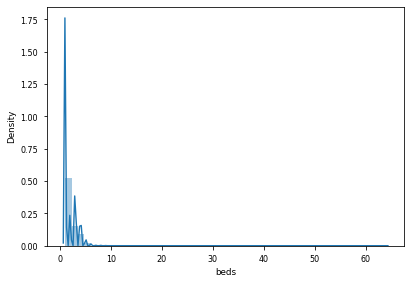

In [46]:
sns.distplot(data_d['beds'])

In [47]:
data_d = data_d[(data_d['beds'] < 10)]

<AxesSubplot:xlabel='beds', ylabel='Density'>

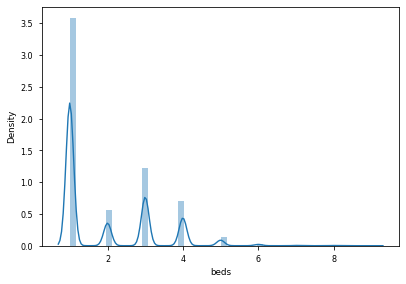

In [48]:
sns.distplot(data_d['beds'])

# Возвращаемся к площади и заполняем пропуски по среднему для группы по комнатам.

In [49]:
data_d['sqft'].fillna(data_d.groupby('beds')['sqft'].transform('mean'), inplace = True)

In [50]:
data_d.head(30)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.000000,28387,1,NC,NaN,NaN,NaN,611019,418000.0
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.000000,99216,3,WA,2.0,NaN,NaN,201916904,310000.0
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",6594.616652,32908,1,FL,NaN,NaN,NaN,861745,5000.0
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897.000000,19145,2,PA,2.0,NaN,NaN,PAPH847006,209000.0
6,Active,NaN,Florida,552 Casanova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...",1507.000000,34759,1,FL,One,NaN,NaN,S5026943,181500.0
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",6594.616652,38115,1,TN,NaN,NaN,NaN,10063506,68000.0
8,Active,NaN,Single Family Home,11182 Owl Ave,2,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588.000000,50401,1,IA,NaN,NaN,NaN,190988,244900.0
9,NaN,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...",1930.000000,77080,1,TX,2.0,NaN,NaN,73968331,311995.0
11,Active,NaN,English,4222 False Cypress Ln,NaN,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Houston,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...",3130.000000,77068,1,TX,2,NaN,NaN,5741322,260000.0
12,for sale,NaN,single-family home,16373 NW 16th St,3 Baths,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Pembroke Pines,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...",2839.000000,33028,4,FL,1.0,NaN,yes,A10767242,525000.0


In [51]:
data_d['sqft'].unique()  

array([2.90000000e+03, 1.94700000e+03, 6.59461665e+03, ...,
       7.20000000e+01, 4.56602479e+08, 7.64400000e+03])

In [52]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276803 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        246682 non-null  object 
 1   private pool  2742 non-null    object 
 2   propertyType  252984 non-null  object 
 3   street        276802 non-null  object 
 4   baths         193984 non-null  object 
 5   homeFacts     276803 non-null  object 
 6   fireplace     67573 non-null   object 
 7   city          276783 non-null  object 
 8   schools       276803 non-null  object 
 9   sqft          276803 non-null  float64
 10  zipcode       276803 non-null  object 
 11  beds          276803 non-null  int64  
 12  state         276803 non-null  object 
 13  stories       169266 non-null  object 
 14  mls-id        19133 non-null   object 
 15  PrivatePool   22747 non-null   object 
 16  MlsId         224478 non-null  object 
 17  target        276803 non-null  float64
dtypes: f

#Визуализация признака площадь (sqft).

<AxesSubplot:xlabel='sqft', ylabel='Density'>

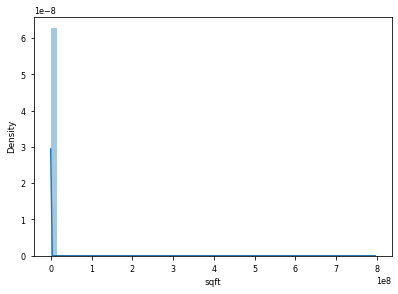

In [53]:
sns.distplot(data_d['sqft'])

In [54]:
data_d = data_d[(data_d['sqft'] < 10000)]

<AxesSubplot:xlabel='sqft', ylabel='Density'>

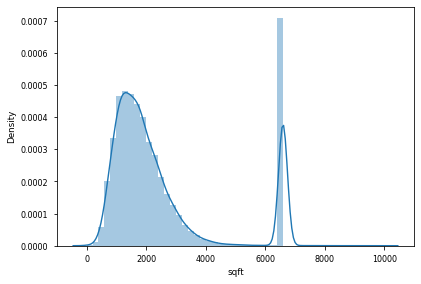

In [55]:

sns.distplot(data_d['sqft'])


# Ванны - приведение к численному виду.

In [56]:
data_d['baths'].unique()   

array(['3.5', '3 Baths', nan, '2', '3', 'Bathrooms: 2', '1,750',
       '4 Baths', '2 ba', '2 Baths', '2.0', '3.0', 'Bathrooms: 1',
       '2.1 Baths', '2.5 Baths', '1', '4.5', 'Bathrooms: 4', '3 ba',
       '4.0', '2,500', '5.5 Baths', '1.0', 'Bathrooms: 3', '1.5', '2.5',
       '4,000', '3.5 Baths', '2,000', '1 ba', '3.5 ba', '0', '1,500',
       '2,250', '1,000', '3,500', '4', '~', '3,000', '2,750', '750',
       '5 Baths', '1.5 ba', '1,250', '1.5 Baths', '6 Baths', '0 / 0',
       '5 ba', '4 ba', '2.5+', '6.0', '4.5 Baths', '-- baths', '7',
       '1.5+', '6', '5,000', '5', '1.1 Baths', 'Bathrooms: 5', '5.5',
       '19 Baths', '1.75 Baths', 'Bathrooms: 6', '13 Baths', '5.0',
       'Sq. Ft. ', '2.5 ba', '3.5+', '7 Baths', 'Bathrooms: 241', '8.0',
       '6.5', 'Bathrooms: 7', '7,500+', '4.5+', '6.5 Baths', '8 Baths',
       '1.75 ba', '0.00', '2.25 Baths', '3.1 Baths', '4.5 ba',
       '2.75 Baths', '0.0', '10', '16 Baths', '7.0', '20.0',
       'Bathrooms: 8', '2 baths', '15 Bath

Вспомогательная функция извлекает численное значение из текста. Если значение некорректно, выдает 1. Применила здесь, а также для обработки этажей.)

In [57]:
def extract_num_recurr(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 1
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num(stroka,len_s,i+1)

def main_extract_num(stroka):   
    len_s=len(stroka)-1
    
    return extract_num(stroka,len_s,0)

In [58]:
data_d.baths = data_d.baths.apply(lambda x: main_extract_num(str(x)))

In [59]:
data_d['baths'].unique()   

array([3.50e+00, 3.00e+00, 1.00e+00, 2.00e+00, 4.00e+00, 2.10e+00,
       2.50e+00, 4.50e+00, 5.50e+00, 1.50e+00, 0.00e+00, 7.50e+02,
       5.00e+00, 6.00e+00, 7.00e+00, 1.10e+00, 1.90e+01, 1.75e+00,
       1.30e+01, 2.41e+02, 8.00e+00, 6.50e+00, 2.25e+00, 3.10e+00,
       2.75e+00, 1.00e+01, 1.60e+01, 2.00e+01, 1.50e+01, 1.10e+01,
       3.25e+00, 3.75e+00, 3.30e+00, 9.00e+00, 1.25e+00, 2.20e+00,
       1.40e+01, 2.50e+01, 5.00e-01, 1.80e+00, 8.50e+00, 1.20e+01,
       2.80e+00, 3.00e+01, 7.50e-01, 4.10e+00])

In [60]:
data_d['baths'].isna().unique()   

array([False])

# Визуализация и обработка признака ванны (baths).

<AxesSubplot:xlabel='baths', ylabel='Density'>

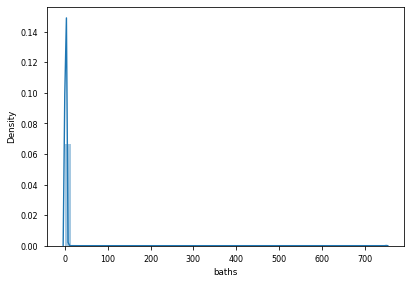

In [61]:
sns.distplot(data_d['baths'])

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [62]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [63]:
data_d['fireplace'].value_counts() 

yes                                                                32792
Yes                                                                13334
1                                                                  10540
Not Applicable                                                      1954
2                                                                    826
                                                                   ...  
Gas Logs, In Den/Family Room, In Living Room, Wood Burning             1
7                                                                      1
Great Room, Natural Gas, Wood Burning                                  1
Air Filter, Ceiling Fan, Central Vacuum, SMTHR, Walk-In Closets        1
Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet                   1
Name: fireplace, Length: 1028, dtype: int64

In [64]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [65]:
data_d['fireplace'].unique()

array([0, 1, 2])

In [66]:
data_d['fireplace'].isna().unique() 

array([False])

# Бассейн. Анализ.

In [67]:
data_d['private pool'].value_counts()

Yes    2729
Name: private pool, dtype: int64

In [68]:
data_d.loc[data_d['private pool'] == 'Yes']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
205,For sale,Yes,Single Family,1403 Betton Rd,2.0,"{'atAGlanceFacts': [{'factValue': '1958', 'fac...",1,Tallahassee,"[{'rating': ['4/10', '5/10', '7/10'], 'data': ...",2361.0,32308,3,FL,NaN,302221,NaN,NaN,385000.0
321,For sale,Yes,Single Family,3296 Ledgewood Cir,3.0,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",0,Riverside,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...",2135.0,92503,3,CA,2.0,IV19242188,NaN,NaN,525000.0
355,For sale,Yes,Mobile / Manufactured,2250 N Broadway # 42,2.0,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",0,Escondido,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...",1536.0,92026,2,CA,0.0,190034991,NaN,NaN,119000.0
425,Pre-foreclosure / auction,Yes,Single Family,7632 Hillside Dr,2.0,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",1,Jacksonville,"[{'rating': ['5/10', '2/10', '4/10'], 'data': ...",1245.0,32221,3,FL,1.0,NaN,NaN,NaN,128103.0
447,For sale,Yes,Single Family,5370 Christie Ann Pl # 17,2.0,"{'atAGlanceFacts': [{'factValue': '1992', 'fac...",0,Sarasota,"[{'rating': ['10/10', '9/10', '6/10'], 'data':...",1936.0,34233,3,FL,1.0,O5821850,NaN,NaN,258000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376298,Pre-foreclosure,Yes,Single Family,15369 Daybreak Ln,3.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",1,Fontana,"[{'rating': ['4/10', '3/10', '4/10'], 'data': ...",2225.0,92337,5,CA,2.0,NaN,NaN,NaN,399094.0
376340,For sale,Yes,Condo,200 River Vista Dr UNIT 436,2.0,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",0,Atlanta,"[{'rating': ['9/10', '6/10', '6/10'], 'data': ...",1299.0,30339,2,GA,1.0,8690633,NaN,NaN,295000.0
376582,For sale,Yes,Single Family,3235 Landover Blvd,2.0,"{'atAGlanceFacts': [{'factValue': '2005', 'fac...",0,Spring Hill,"[{'rating': ['4/10', '6/10'], 'data': {'Distan...",2256.0,34609,4,FL,1.0,2204520,NaN,NaN,225000.0
376686,For sale,Yes,Single Family,2609 S Marigold Ave,3.0,"{'atAGlanceFacts': [{'factValue': '1979', 'fac...",0,Ontario,"[{'rating': ['7/10', '6/10', '5/10'], 'data': ...",1726.0,91761,3,CA,2.0,IV19252050,NaN,NaN,479000.0


Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [69]:
data_d['propertyType'].value_counts(normalize=True)

single-family home                                             0.275108
Single Family                                                  0.183103
Single Family Home                                             0.097868
lot/land                                                       0.068911
condo                                                          0.065882
                                                                 ...   
Traditional, Loft with Bedrooms                                0.000004
Condo/Townhome, French, Split Level                            0.000004
Traditional, Colonial, Federal                                 0.000004
Multi Generational                                             0.000004
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000004
Name: propertyType, Length: 893, dtype: float64

In [70]:
data_d.propertyType = data_d.propertyType.apply(lambda x: str(x))

In [71]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [72]:
data_d['propertyType'].value_counts(normalize=True)

sfh                                                            0.508127
nan                                                            0.086232
lot/land                                                       0.062969
condo                                                          0.060201
Condo                                                          0.041190
                                                                 ...   
Multi Generational                                             0.000004
Manufactured (Certificate Exchange)                            0.000004
Single Detached, Contemporary/Modern, Southwestern             0.000004
Farmhouse, Multi-Family                                        0.000004
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000004
Name: propertyType, Length: 892, dtype: float64

In [73]:
data_d.propertyType = data_d.propertyType.apply(lambda x: x.lower())

In [74]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'mlf' if (x.find('multi')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'ctmp' if (x.find('contempor')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'loft' if (x.find('loft')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'twnh' if (x.find('townhouse')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'condo' if (x.find('condo')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sn_dtch' if (x.find('single detached')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'eng' if (x.find('english')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'other' if x not in ['mlf','ctmp','loft','twnh','condo','sn_dtch','eng'] else x)

In [75]:
data_d['propertyType'].value_counts()

other      215130
condo       34375
twnh        14318
mlf          5918
ctmp         2875
sn_dtch      2269
loft           33
eng            27
Name: propertyType, dtype: int64

Преобразование к численному виду.

In [76]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes

In [77]:
data_d['propertyType_cat'].value_counts()

5    215130
0     34375
7     14318
4      5918
1      2875
6      2269
3        33
2        27
Name: propertyType_cat, dtype: int64

In [78]:
data_d['propertyType'].isna().unique() 

array([False])

In [79]:
#plt.violinplot(data_d['propertyType'])

 # площадь

In [80]:
#data_d.beds = data_d.beds.apply(lambda x: 500 if (x==0 & data_d['sqft']!=0) else x)

# Город

In [81]:
data_d['city'].value_counts()

Houston         19033
San Antonio     14429
Miami           10085
Jacksonville     9191
Dallas           5958
                ...  
EVERGREEN           1
Downs               1
Stanwood            1
SUNRISE             1
Blue Springs        1
Name: city, Length: 1805, dtype: int64

In [82]:
data_d['city'] = data_d['city'].astype('category')
data_d['city_cat'] = data_d['city'].cat.codes

In [83]:
data_d['city_cat'].value_counts()

713     19033
1408    14429
989     10085
755      9191
379      5958
        ...  
436         1
417         1
1551        1
1383        1
155         1
Name: city_cat, Length: 1806, dtype: int64

In [84]:
data_d['city_cat'].isna().unique()

array([False])

# Штат

In [85]:
data_d['state'].value_counts()

FL    90173
TX    68389
NC    17910
TN    15130
OH    11604
CA     8705
WA     7826
NY     7073
IL     6971
NV     6554
GA     5085
MI     4951
PA     4734
CO     4366
AZ     3084
IN     3059
DC     1886
OR     1739
UT      903
MO      807
VT      770
MD      763
MA      552
VA      508
WI      388
NJ      318
ME      251
IA      232
KY       85
OK       49
MS       38
SC       26
MT        7
DE        4
Fl        1
BA        1
AL        1
OT        1
OS        1
Name: state, dtype: int64

In [86]:
data_d['state'] = data_d['state'].astype('category')
data_d['state_cat'] = data_d['state'].cat.codes

In [87]:
data_d['state_cat'].value_counts()

7     90173
33    68389
21    17910
32    15130
25    11604
3      8705
37     7826
24     7073
11     6971
23     6554
9      5085
17     4951
30     4734
4      4366
1      3084
12     3059
5      1886
27     1739
34      903
18      807
36      770
15      763
14      552
35      508
38      388
22      318
16      251
10      232
13       85
26       49
19       38
31       26
20        7
6         4
8         1
2         1
0         1
29        1
28        1
Name: state_cat, dtype: int64

In [88]:
data_d['state_cat'].isna().unique()

array([False])

# Улица

In [89]:
data_d['street'].head(50)

0                    240 Heather Ln
1                 12911 E Heroy Ave
4                    1524 Kiscoe St
5                 1624 S Newkirk St
6                  552 Casanova Ct 
7                   6094 Mingle Dr 
8                     11182 Owl Ave
9              8612 Cedar Plains Ln
11           4222 False Cypress Ln 
12                 16373 NW 16th St
13                   1538 Umpqua Dr
14               15351 Falmouth Ave
16                 2402 NW 22nd Rd 
18               22702 Alderdale Ln
20                 5930 E Avenue T2
23             4234 Orchard Pass Dr
24                  703 W Gemini Ln
27             2104 Lou Ellen Ln #B
31                  6712 N Glen Ave
32              2043 SE New York St
33         3750 NE 170th St APT 407
34                7314 Melvin Cir N
35            423 N Church St #13-A
36                2627 N Arthur Ave
37                  3360 SW 29th St
38           5531 Eureka Springs Rd
39           316 N Henderson Ave #4
40                1104 Roton

In [90]:
x_str=data_d['street']
y = data_d['target']

In [91]:
#plt.figure(figsize = (10,6))
#plt.scatter(x_str, y)
 
# добавим подписи
#plt.xlabel('Улица', fontsize = 15)
#plt.ylabel('Цена', fontsize = 15)
#plt.title('Зависимость цены от улицы', fontsize = 18)

 # Stories (надеюсь, это этажи)

In [92]:
data_d['stories'].value_counts()

1.0                                           56663
2.0                                           38943
1                                             19808
2                                             12446
3.0                                            6148
                                              ...  
None                                              1
2 Story or 2 Level                                1
Sixplex                                           1
Townhouse-2 Story, T3-Townhouse 3+ Stories        1
Patio Home                                        1
Name: stories, Length: 271, dtype: int64

In [93]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num(str(x)))


In [94]:
data_d['stories'].value_counts()

1.00       195059
2.00        55926
3.00         9333
0.00         7763
9.00         2043
4.00         1621
1.50         1144
6.00          520
5.00          460
8.00          218
7.00          190
2.50          142
16.00          48
12.00          36
15.00          36
11.00          33
10.00          29
17.00          28
13.00          26
1.75           25
20.00          24
14.00          22
21.00          21
25.00          21
1.70           17
18.00          16
22.00          15
27.00          14
23.00          14
24.00          12
26.00           9
19.00           8
43.00           8
29.00           8
28.00           5
42.00           4
33.00           4
32.00           4
36.00           4
31.00           3
30.00           3
49.00           3
47.00           3
46.00           2
35.00           2
57.00           2
56.00           2
1.30            2
48.00           2
45.00           1
1.20            1
60.00           1
55.00           1
40.00           1
1120.00         1
41.00     

In [95]:
data_d['stories'].isna().unique()

array([False])

 # Status

In [96]:
data_d['status'].value_counts()

for sale                111922
Active                   76639
For sale                 30181
foreclosure               5870
Pending                   4059
                         ...  
Pending Sale                 1
Coming soon: Nov 30.         1
Coming soon: Dec 16.         1
Coming soon: Dec 18.         1
Accepting backups            1
Name: status, Length: 152, dtype: int64

In [97]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

In [98]:
data_d.status = data_d.status.apply(lambda x: str(x))

In [99]:
data_d.status = data_d.status.apply(lambda x: x.lower())

In [100]:
data_d.status = data_d.status.apply(lambda x: 'actv' if (x.find('activ')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cnstr' if (x.find('construction')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntrct' if (x.find('contract')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'pnd' if (x.find('pending')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntgs' if (x.find('contingen')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cmg_s' if (x.find('coming soon')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)

In [101]:
data_d['status'].unique()

array(['actv', 'for_sale', 'nan', 'cnstr', 'pnd', 'frcls', ' / auction',
       'cntrct', 'p', 'foreclosed', 'for rent', 'auction', 'cntgs',
       'price change', 'back on market', 'new', 'recently sold', 'cmg_s',
       'pf', 'apartment for rent', 'pi', 'due diligence period',
       'c continue show', 'closed', 'for sale', 'c', 'condo for rent',
       'ct', 'accepted offer', 'listing extended',
       'conting accpt backups', 'lease/purchase', 'sold: $285,000',
       'sold: $15,000', 'ps', 'uc continue to show', 'backup',
       'accepting backups'], dtype=object)

In [102]:
data_d['status'].value_counts()

for_sale                 142103
actv                      77465
nan                       30107
frcls                      9461
pnd                        4627
cnstr                      3399
cntrct                     2593
cntgs                       935
p                           781
 / auction                  691
auction                     486
new                         452
foreclosed                  436
price change                406
for rent                    389
recently sold               287
back on market              101
cmg_s                        78
pi                           29
due diligence period         26
c                            18
c continue show              18
closed                       17
listing extended              8
condo for rent                6
apartment for rent            5
accepted offer                4
ct                            3
pf                            3
ps                            2
uc continue to show           2
for sale

Приведение к численному виду.

In [103]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes

In [104]:
data_d['status'].isna().unique()

array([False])

# Индекс

In [105]:
#data_d['zipcode'].value_counts()

In [106]:
#data_d['zipcode'].unique()

In [107]:
#data_d.zipcode = data_d.zipcode.apply(lambda x: 0 if (x.find('-')>-1) else x)

In [108]:
#data_d.zipcode = data_d.zipcode.apply(lambda x: float(x))

In [109]:
#data_d['zipcode'].value_counts()

In [110]:
#data_d['zipcode'].isna().unique()

In [111]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274945 entries, 0 to 377184
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            274945 non-null  category
 1   private pool      2729 non-null    object  
 2   propertyType      274945 non-null  category
 3   street            274944 non-null  object  
 4   baths             274945 non-null  float64 
 5   homeFacts         274945 non-null  object  
 6   fireplace         274945 non-null  int64   
 7   city              274925 non-null  category
 8   schools           274945 non-null  object  
 9   sqft              274945 non-null  float64 
 10  zipcode           274945 non-null  object  
 11  beds              274945 non-null  int64   
 12  state             274945 non-null  category
 13  stories           274945 non-null  float64 
 14  mls-id            19029 non-null   object  
 15  PrivatePool       22629 non-null   object  
 16  Ml

# Обработка признака homeFacts.

In [6]:
data_d['homeFacts'].value_counts()

{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                                        7174
{'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                             3532
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'

In [7]:
data_d['homeFacts'].isna().sum()

0

Вспомогательная функция для извлечения списка значимых величин из признака. (Извлекает список словарей из исходной структуры, которая тоже является словарем. Затем по ключевым словам словаря формирует список значимых величин. Возвращает нан, если в списке отсутствует ключевое слово основного словаря.)

In [22]:
def facts_extraction(slovar):
    if (str(slovar).find('atAGlanceFacts')>-1):
        slovar1 = eval(slovar)
        
        
        slovar2=slovar1.get('atAGlanceFacts')
        
        
        
        lst = ['']
        for i in slovar2:
            
            lst.append(i.get('factValue'))
        lst_res=lst[1:]
        return lst_res
            
    else: return np.NaN

In [23]:
data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))

In [ ]:
data_d['homeFacts'].value_counts()

In [ ]:
data_d.head(5)

status        246827 non-null  object 
 1   private pool  2742 non-null    object 
 2   propertyType  253129 non-null  object 
 3   street        276947 non-null  object 
 4   baths         194069 non-null  object 
 5   homeFacts     276948 non-null  object 
 6   fireplace     67586 non-null   object 
 7   city          276928 non-null  object 
 8   schools       276948 non-null  object 
 9   sqft          235646 non-null  float64
 10  zipcode       276948 non-null  object 
 11  beds          276948 non-null  int64  
 12  state         276948 non-null  object 
 13  stories       169302 non-null  object 
 14  mls-id        19149 non-null   object 
 15  PrivatePool   22749 non-null   object 
 16  MlsId         224599 non-null  object 
 17  target 

In [ ]:
data_d_1 = pd.concat([data_d['private pool','propertyType','street','baths','homeFacts',
                             'fireplace','city','schools','sqft','zipcode','beds','state','stories','mls-id','PrivatePool','MlsId','target'],
                      data_d['homeFacts'].str.split(', ', expand=True)], axis=1)

In [ ]:
data_d_1.head(5)

# Выбор предварительного датафрейма для модели

In [112]:
data_d_preliminary=data_d[['propertyType_cat','baths','fireplace','sqft','beds','stories','status_cat','city_cat','state_cat','target']]

In [113]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274945 entries, 0 to 377184
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   propertyType_cat  274945 non-null  int8   
 1   baths             274945 non-null  float64
 2   fireplace         274945 non-null  int64  
 3   sqft              274945 non-null  float64
 4   beds              274945 non-null  int64  
 5   stories           274945 non-null  float64
 6   status_cat        274945 non-null  int8   
 7   city_cat          274945 non-null  int16  
 8   state_cat         274945 non-null  int8   
 9   target            274945 non-null  float64
dtypes: float64(4), int16(1), int64(2), int8(3)
memory usage: 16.0 MB


In [114]:
#data_d_test=data_d[['sqft','target']]

In [115]:
data_d_preliminary

,propertyType_cat,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,target
0,5,3.5,0,2900.000000,1,1.0,3,1511,21,418000.0
1,5,3.0,0,1947.000000,3,2.0,21,1519,37,310000.0
4,5,1.0,0,6594.616652,1,1.0,21,1187,7,5000.0
5,7,1.0,0,897.000000,2,2.0,21,1225,30,209000.0
6,5,1.0,0,1507.000000,1,1.0,3,1180,7,181500.0
...,...,...,...,...,...,...,...,...,...,...
377177,6,1.0,0,1895.000000,1,1.0,3,542,33,199900.0
377178,5,2.0,0,1841.000000,1,1.0,26,713,33,252990.0
377182,5,3.0,0,1152.000000,3,2.0,21,757,24,528000.0
377183,5,1.0,0,6594.616652,1,1.0,26,713,33,34500.0


In [116]:
data_d_preliminary.isna().sum()

propertyType_cat    0
baths               0
fireplace           0
sqft                0
beds                0
stories             0
status_cat          0
city_cat            0
state_cat           0
target              0
dtype: int64

In [117]:
data_d_preliminary['propertyType_cat'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['baths'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['beds'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['stories'].fillna(method = 'ffill', inplace = True)


In [118]:
data_d_preliminary.isna().sum()

propertyType_cat    0
baths               0
fireplace           0
sqft                0
beds                0
stories             0
status_cat          0
city_cat            0
state_cat           0
target              0
dtype: int64

# Визуализация

(10.5, -0.5)

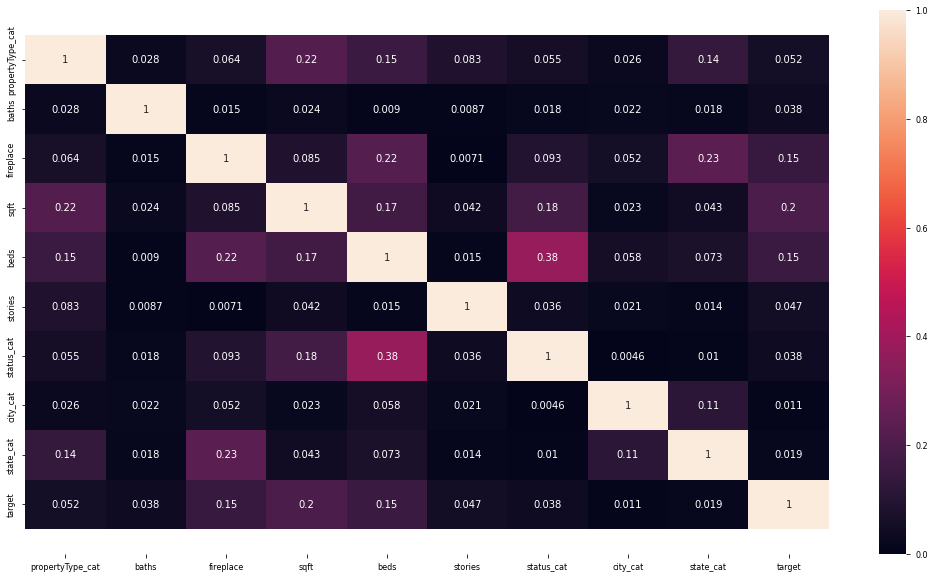

In [119]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [120]:
#  подготовка данных для графиков
x1 = data_d_preliminary['propertyType_cat']
x2 = data_d_preliminary['city_cat']
x3 = data_d_preliminary['baths']
x4 = data_d_preliminary['fireplace']
x5 = data_d_preliminary['sqft']
x6 = data_d_preliminary['beds']
x7 = data_d_preliminary['stories']
x8 = data_d_preliminary['state_cat']
x9 = data_d_preliminary['status_cat']
#x10 = data_d_preliminary['zipcode']
#sdsfdf

y = data_d_preliminary['target']

Text(0.5, 1.0, 'Зависимость цены от статуса продажи')

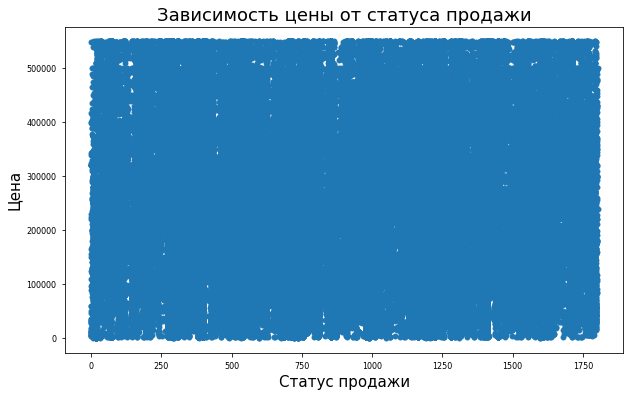

In [121]:
plt.figure(figsize = (10,6))
plt.scatter(x2, y)
 
# добавим подписи
plt.xlabel('Статус продажи', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от типа недвижимости')

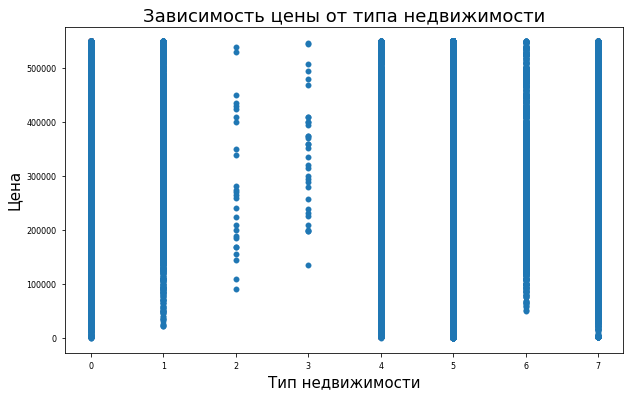

In [122]:
plt.figure(figsize = (10,6))
plt.scatter(x1, y)
 
# добавим подписи
plt.xlabel('Тип недвижимости', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от типа недвижимости', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от наличия камина')

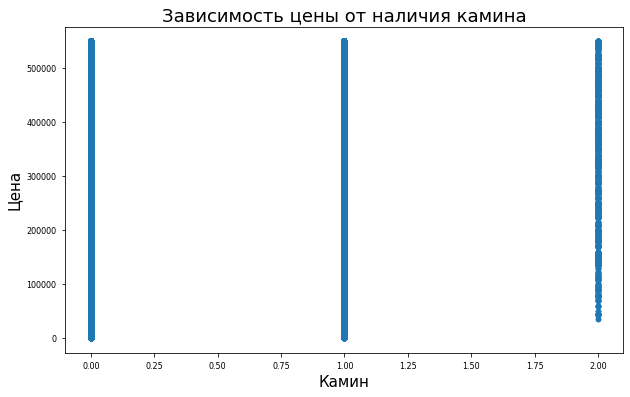

In [123]:
plt.figure(figsize = (10,6))
plt.scatter(x4, y)
 
# добавим подписи
plt.xlabel('Камин', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от площади')

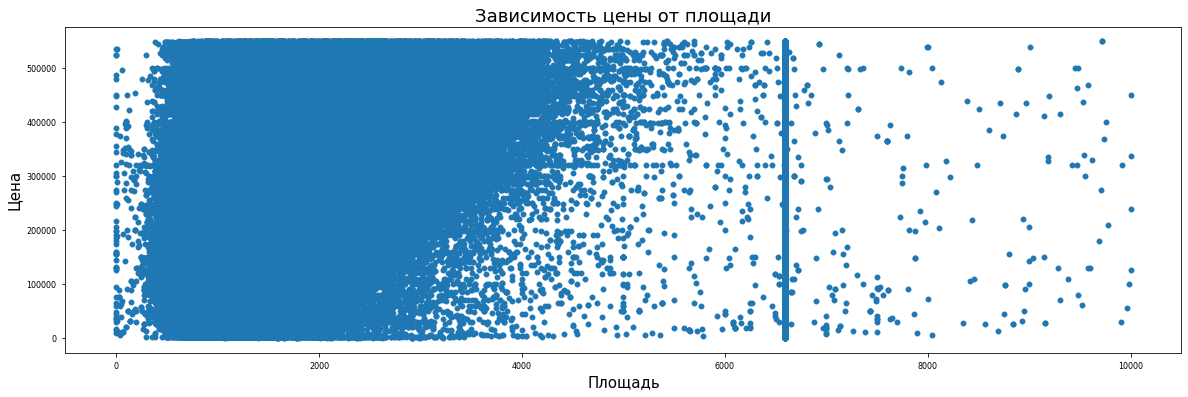

In [124]:
plt.figure(figsize = (20,6))
plt.scatter(x5, y)
 
# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

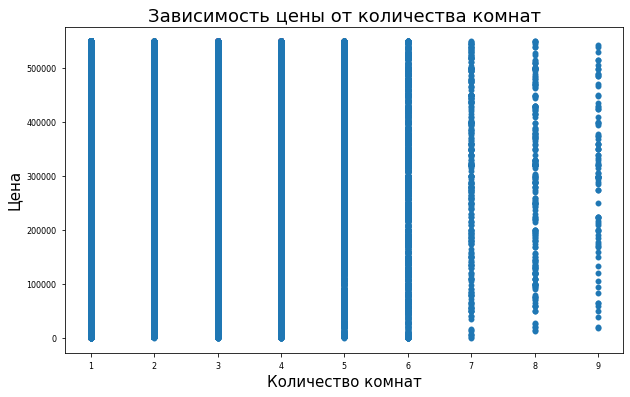

In [125]:
plt.figure(figsize = (10,6))
plt.scatter(x6, y)
 
# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от этажа')

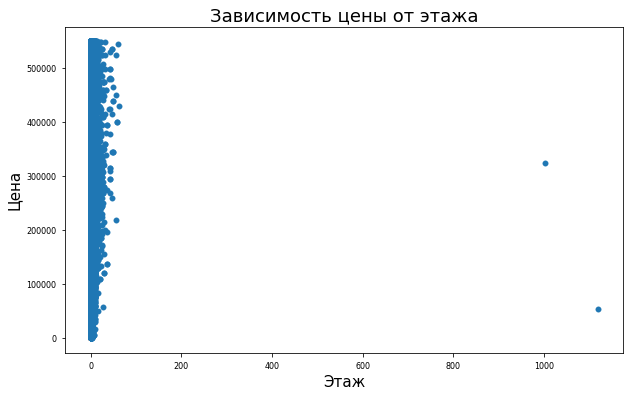

In [126]:
plt.figure(figsize = (10,6))
plt.scatter(x7, y)
 
# добавим подписи
plt.xlabel('Этаж', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от города')

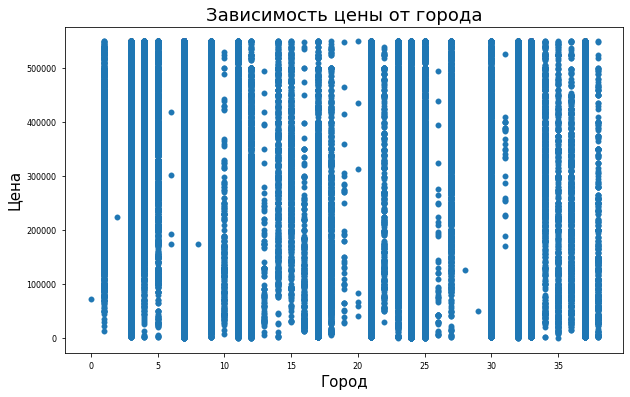

In [127]:
plt.figure(figsize = (10,6))
plt.scatter(x8, y)
 
# добавим подписи
plt.xlabel('Город', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от города', fontsize = 18)

<AxesSubplot:xlabel='propertyType_cat'>

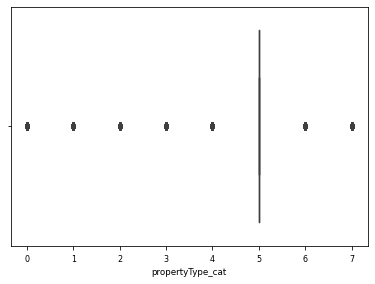

In [128]:
sns.boxplot(data_d_preliminary['propertyType_cat'])

<AxesSubplot:xlabel='propertyType_cat'>

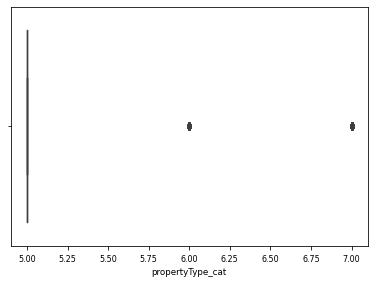

In [129]:
data_d_preliminary['propertyType_cat'] = data_d_preliminary[(data_d_preliminary['propertyType_cat'] > 4)]['propertyType_cat']
sns.boxplot(data_d_preliminary['propertyType_cat'])

<AxesSubplot:xlabel='baths'>

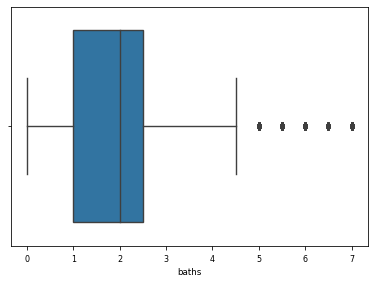

In [130]:
data_d_preliminary['baths'] = data_d_preliminary[(data_d_preliminary['baths'] < 8)]['baths']
sns.boxplot(data_d_preliminary['baths'])

<AxesSubplot:xlabel='fireplace'>

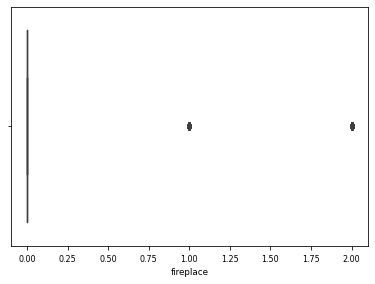

In [131]:
sns.boxplot(data_d_preliminary['fireplace'])

<AxesSubplot:xlabel='sqft'>

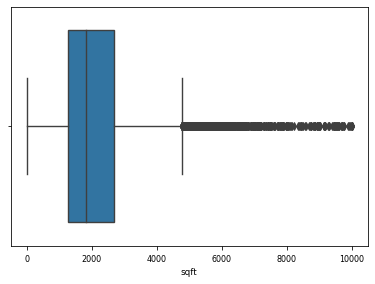

In [132]:
sns.boxplot(data_d_preliminary['sqft'])

<AxesSubplot:xlabel='beds'>

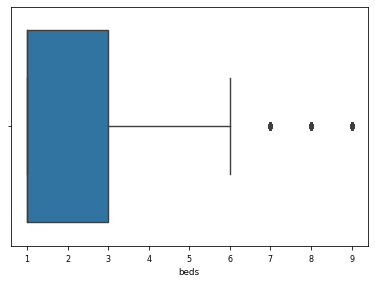

In [133]:
sns.boxplot(data_d_preliminary['beds'])

<AxesSubplot:xlabel='beds'>

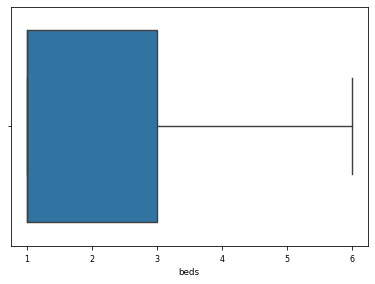

In [134]:
data_d_preliminary['beds'] = data_d_preliminary[(data_d_preliminary['beds'] < 7)]['beds']
sns.boxplot(data_d_preliminary['beds'])

<AxesSubplot:xlabel='stories'>

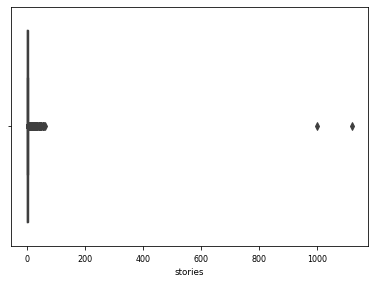

In [135]:
sns.boxplot(data_d_preliminary['stories'])

<AxesSubplot:xlabel='stories'>

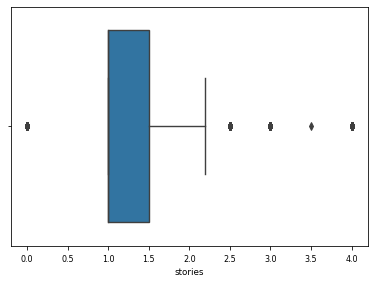

In [136]:
data_d_preliminary['stories'] = data_d_preliminary[(data_d_preliminary['stories'] < 5)]['stories']
sns.boxplot(data_d_preliminary['stories'])

<AxesSubplot:xlabel='state_cat'>

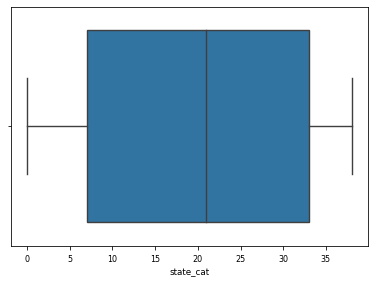

In [137]:
sns.boxplot(data_d_preliminary['state_cat'])

<AxesSubplot:xlabel='city_cat'>

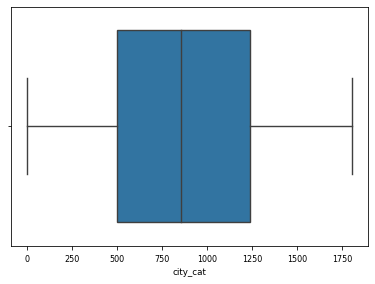

In [138]:
sns.boxplot(data_d_preliminary['city_cat'])

In [139]:

#data_d_preliminary['state_cat'] = data_d_preliminary[(data_d_preliminary['state_cat'] < 500 ) | (data_d_preliminary['sity_state_cat'] > 1700)]['sity_state_cat']
#sns.boxplot(data_d_preliminary['sity_state_cat'])

377185

In [140]:
#data_d_preliminary.isna().sum()

In [141]:
#values = {'propertyType_cat':1275}
#data_d_preliminary = data_d_preliminary.fillna(value=values)

In [142]:
#data_d_preliminary = data_d_preliminary.dropna()

In [143]:
#data_d_preliminary.isnull().sum()

(10.5, -0.5)

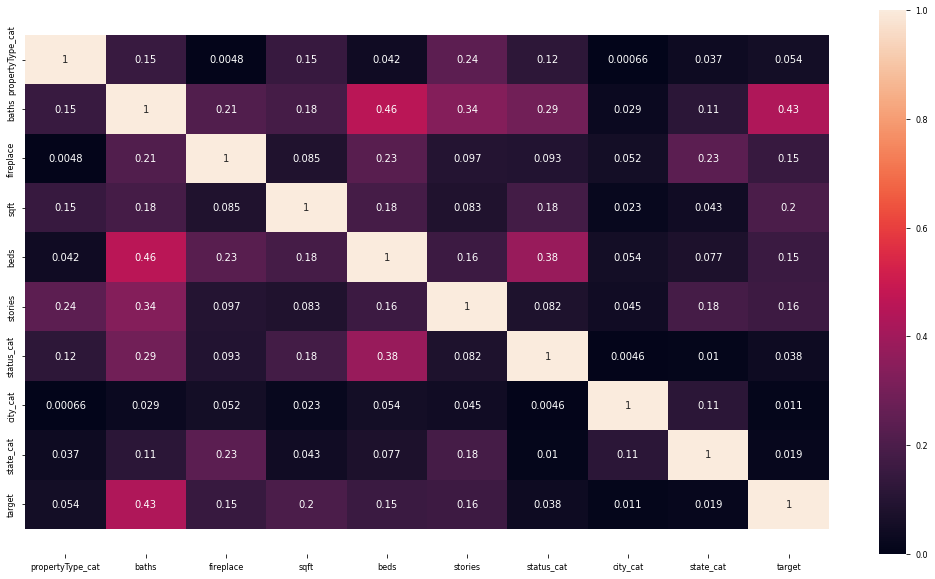

In [144]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

# Нормализация

In [145]:
# min_maz_Scaler=preprocessing.MinMaxScaler()

In [146]:
# col=data_d_preliminary.columns
# result=min_maz_Scaler.fit_transform(data_d_preliminary)
# data_d_preliminaty_n=pd.DataFrame(result,columns=col)

In [147]:
# data_d_preliminaty_n

In [148]:
#plt.figure(figsize=(18, 10))
#ax = sns.heatmap(data_d_preliminaty_n.corr().abs(), vmin=0, vmax=1, annot = True)
#i, k = ax.get_ylim()
#ax.set_ylim(i+0.5, k-0.5)

> # Грубая модель

In [149]:
data_d_preliminary

,propertyType_cat,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,target
0,5.0,3.5,0,2900.000000,1.0,1.0,3,1511,21,418000.0
1,5.0,3.0,0,1947.000000,3.0,2.0,21,1519,37,310000.0
4,5.0,1.0,0,6594.616652,1.0,1.0,21,1187,7,5000.0
5,7.0,1.0,0,897.000000,2.0,2.0,21,1225,30,209000.0
6,5.0,1.0,0,1507.000000,1.0,1.0,3,1180,7,181500.0
...,...,...,...,...,...,...,...,...,...,...
377177,6.0,1.0,0,1895.000000,1.0,1.0,3,542,33,199900.0
377178,5.0,2.0,0,1841.000000,1.0,1.0,26,713,33,252990.0
377182,5.0,3.0,0,1152.000000,3.0,2.0,21,757,24,528000.0
377183,5.0,1.0,0,6594.616652,1.0,1.0,26,713,33,34500.0


In [150]:
data_d_preliminary.isna().sum()

propertyType_cat    43228
baths                 229
fireplace               0
sqft                    0
beds                  578
stories              3910
status_cat              0
city_cat                0
state_cat               0
target                  0
dtype: int64

In [151]:
data_d_preliminary['propertyType_cat'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['baths'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['beds'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['stories'].fillna(method = 'ffill', inplace = True)


In [152]:
data_d_preliminary.isna().sum()

propertyType_cat    0
baths               0
fireplace           0
sqft                0
beds                0
stories             0
status_cat          0
city_cat            0
state_cat           0
target              0
dtype: int64

In [153]:
# data_d_preliminary=data_d_preliminary.dropna()

In [154]:
X=data_d_preliminary[['propertyType_cat','baths','fireplace','sqft','beds','stories','status_cat','city_cat','state_cat']]

In [155]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274945 entries, 0 to 377184
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   propertyType_cat  274945 non-null  float64
 1   baths             274945 non-null  float64
 2   fireplace         274945 non-null  int64  
 3   sqft              274945 non-null  float64
 4   beds              274945 non-null  float64
 5   stories           274945 non-null  float64
 6   status_cat        274945 non-null  int8   
 7   city_cat          274945 non-null  int16  
 8   state_cat         274945 non-null  int8   
dtypes: float64(5), int16(1), int64(1), int8(2)
memory usage: 15.7 MB


In [156]:
X

,propertyType_cat,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat
0,5.0,3.5,0,2900.000000,1.0,1.0,3,1511,21
1,5.0,3.0,0,1947.000000,3.0,2.0,21,1519,37
4,5.0,1.0,0,6594.616652,1.0,1.0,21,1187,7
5,7.0,1.0,0,897.000000,2.0,2.0,21,1225,30
6,5.0,1.0,0,1507.000000,1.0,1.0,3,1180,7
...,...,...,...,...,...,...,...,...,...
377177,6.0,1.0,0,1895.000000,1.0,1.0,3,542,33
377178,5.0,2.0,0,1841.000000,1.0,1.0,26,713,33
377182,5.0,3.0,0,1152.000000,3.0,2.0,21,757,24
377183,5.0,1.0,0,6594.616652,1.0,1.0,26,713,33


In [157]:
data_d_preliminary.isna().sum()

propertyType_cat    0
baths               0
fireplace           0
sqft                0
beds                0
stories             0
status_cat          0
city_cat            0
state_cat           0
target              0
dtype: int64

In [158]:
#X_tes = data_d_test[['sqft']]
#y_tes = data_d_test[['target']]

In [159]:
#X_tes

In [160]:

y = data_d_preliminary[['target']]
y

#X1 = data_d_preliminary[['sity_state_cat','baths','beds']]

,target
0,418000.0
1,310000.0
4,5000.0
5,209000.0
6,181500.0
...,...
377177,199900.0
377178,252990.0
377182,528000.0
377183,34500.0


In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [162]:
extra_tree = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
extra_tree.fit(X_train, y_train)
predict_extra_tree = extra_tree.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)
print(np.array(y_test.index.values))
# оцениваем точность
print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


[146195  86699 298224 ... 358630 315379  21260]
7.002101828653443


In [163]:
print(np.array(y_test.index.values))

[146195  86699 298224 ... 358630 315379  21260]


In [164]:
print(mape(np.array(y_test.index.values), predict_extra_tree))

7.002101828653443


In [165]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 118618.1534083	test: 118620.0346634	best: 118620.0346634 (0)	total: 340ms	remaining: 5m 39s
100:	learn: 82196.0129646	test: 85119.0179405	best: 85119.0179405 (100)	total: 10.2s	remaining: 1m 30s
200:	learn: 78374.7968020	test: 83645.8076009	best: 83645.8076009 (200)	total: 15s	remaining: 59.7s
300:	learn: 75986.5032041	test: 83158.9925496	best: 83158.9925496 (300)	total: 19.8s	remaining: 45.9s
400:	learn: 74286.5807580	test: 82961.3360916	best: 82960.3451081 (399)	total: 24.5s	remaining: 36.6s
500:	learn: 72884.7174332	test: 82863.9465112	best: 82863.9465112 (500)	total: 29.4s	remaining: 29.3s
600:	learn: 71680.0361708	test: 82824.6763722	best: 82805.8656682 (590)	total: 34.2s	remaining: 22.7s
700:	learn: 70666.3515785	test: 82849.6382135	best: 82805.8656682 (590)	total: 38.9s	remaining: 16.6s
800:	learn: 69739.7928965	test: 82888.7006907	best: 82805.8656682 (590)	total: 44s	remaining: 10.9s
900:	learn: 68876.7733617	test: 82973.0980644	best: 82805.8656682 (590)	total: 48.8s	

In [166]:
predict_catboost = catboost.predict(X_test)
#predict_catboost_exp=np.exp(predict_catboost)

#predict_catboost_exp

In [167]:
print(f"MAPE: {(mape_log(y_test, predict_catboost))*100:0.2f}%")

ValueError: Unable to coerce to Series, length must be 1: given 90732

In [ ]:
predict_catboost 

In [ ]:
y_test1=y_test.index.values

In [ ]:
y_test1

In [ ]:
print_regression_metrics(y_test1, predict_catboost)

In [ ]:
print(f"MAPE: {(mape_log(y_test1, predict_catboost))*100:0.2f}%")

In [ ]:
model = LinearRegression()


In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
y_pred_exp=np.exp(y_pred)
y_pred_exp

In [ ]:
from sklearn import metrics

In [ ]:
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


In [ ]:
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:

#logisticRegr = LogisticRegression()
#logisticRegr.fit(X_train, y_train)
# Returns a NumPy Array
# Predict for One Observation (image)
#logisticRegr.predict(x_test[0].reshape(1,-1))
#logisticRegr.predict(x_test[0:10])
#predictions = logisticRegr.predict(x_test)
# Use score method to get accuracy of model
#score = logisticRegr.score(X_test, y_test)
#print(score)

In [ ]:
logreg = LogisticRegression(solver='liblinear', max_iter=50)

logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

probs = logreg.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [172]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model =  RandomForestRegressor(n_estimators=10 ,
                               oob_score=True,
                               random_state=RANDOM_SEED)
model.fit(X_train, y_train) # обучение
a = model.predict(X_test) # предсказание
a

score = model.score(X_train, y_train)
print("R-squared:", score) 
#print ("AUC-ROC (oob) = ", roc_auc_score(y_train, model.oob_prediction_))
#print ("AUC-ROC (test) = ", roc_auc_score(y_test, a))

R-squared: 0.8608178403778735


In [174]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 


MSE:  7682148008.759693
RMSE:  3841074004.3798466


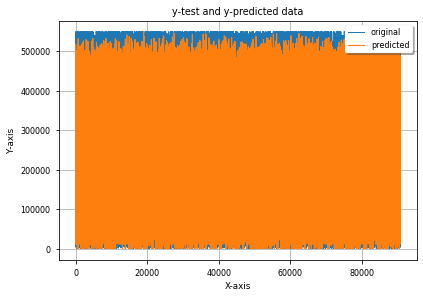

In [175]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [177]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

AttributeError: 'RandomForestRegressor' object has no attribute 'predict_proba'

In [ ]:
feature_importance=catboost.feature_importances_
sorted_idx=np.argsort(feature_importance)
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align='center')
plt.yticks(range(len(sorted_idx)),np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()